# Project 1: End-to-End Pipeline to Classify News Articles

## Question 1

### 1.1 Overview How many rows (samples) and columns (features) are present in the dataset?

In [63]:
import pandas as pd

df = pd.read_csv('Project1-ClassificationDataset.csv')

num_rows, num_cols = df.shape

print(f"Number of rows (samples): {num_rows}")
print(f"Number of cols (features): {num_cols}")

Number of rows (samples): 3476
Number of cols (features): 8


### 1.2 Histograms

#### (a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis

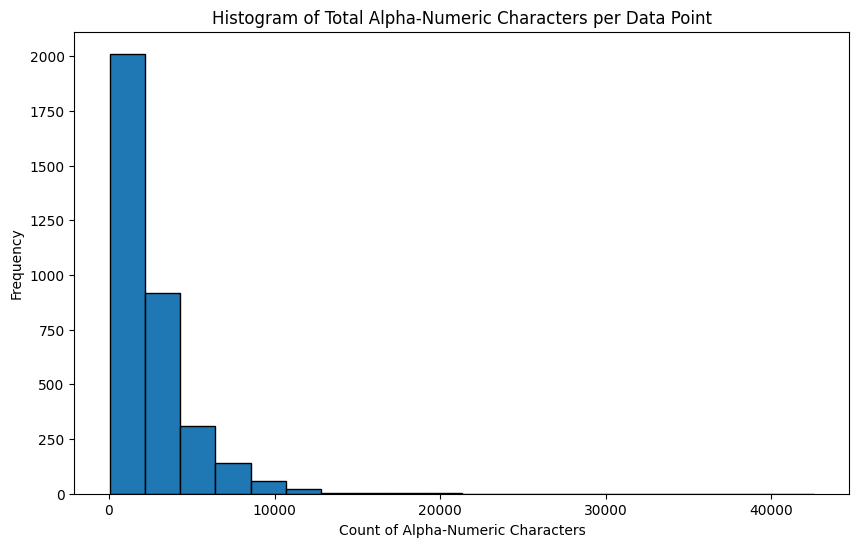

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV file into a DataFrame
file_path = 'Project1-ClassificationDataset.csv'
df = pd.read_csv(file_path)

# (a) Histogram for the total number of alpha-numeric characters per data point
df['Total_AlphaNumeric_Count'] = df['full_text'].apply(lambda x: sum(c.isalnum() for c in str(x)))
plt.figure(figsize=(10, 6))
plt.hist(df['Total_AlphaNumeric_Count'], bins=20, edgecolor='black')
plt.title('Histogram of Total Alpha-Numeric Characters per Data Point')
plt.xlabel('Count of Alpha-Numeric Characters')
plt.ylabel('Frequency')
plt.show()

#### (b) The column leaf label – class on the x-axis

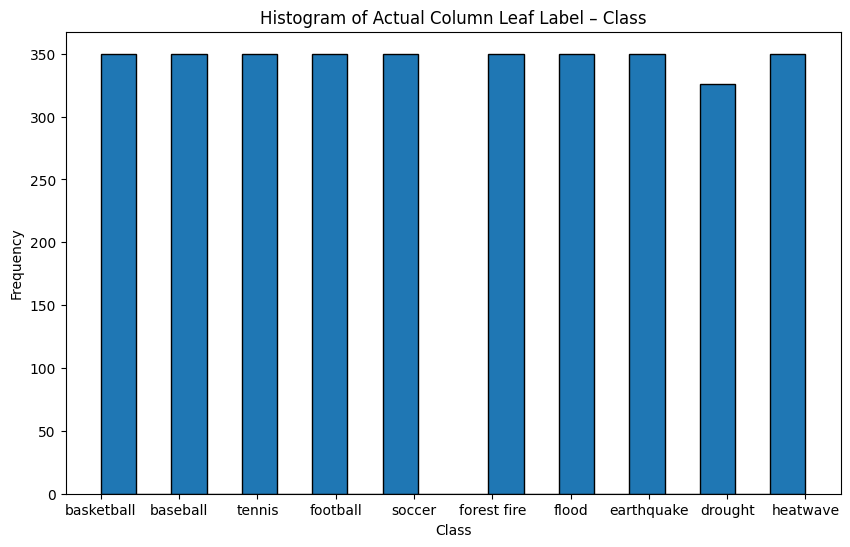

In [65]:
# (b) Histogram for the actual column leaf label – class
leaf_label_column = 'leaf_label'  
plt.figure(figsize=(10, 6))
plt.hist(df[leaf_label_column], bins=20, edgecolor='black')
plt.title('Histogram of Actual Column Leaf Label – Class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


#### (c) The column root label – class on the x-axis.

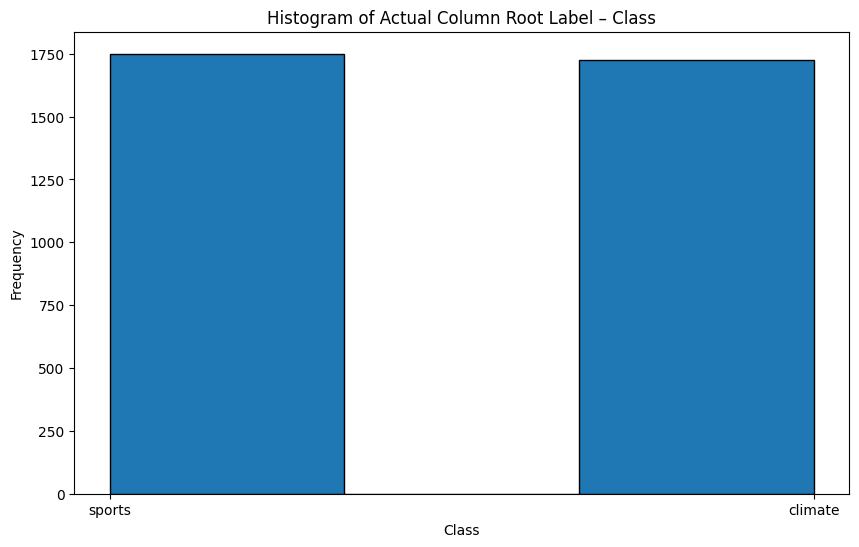

In [66]:
# (c) Histogram for the actual column root label – class
root_label_column = 'root_label'  
plt.figure(figsize=(10, 6))
plt.hist(df[root_label_column], bins=3, edgecolor='black')
plt.title('Histogram of Actual Column Root Label – Class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

### 1.3 Interpret Plots: Provide qualitative interpretations of the histograms.

** incomplete **

(a) Histogram of Alpha Numeric Characters per Data Point
- Histogram reveals the distribution of the total number of alpha-numeric characters in the 'full_text' feature for each data point

(b) Histogram of Leaf Label Class
- b

(c) Histogram of Root Label Class
- c

## Question 2: Splitting Dataset

In [67]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)

### Report the number of training and testing samples.

In [68]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)

num_training_samples = len(train)
num_testing_samples = len(test)

print(f"Number of training samples: {num_training_samples}")
print(f"Number of testing samples: {num_testing_samples}")

Number of training samples: 2780
Number of testing samples: 696


## Question 3: Feature Extraction (Lemmatize and Vectorize)


### 3.1 Cleaning each data sample. This function helps remove many but not all HTML artefacts from the crawler’s output. 

In [69]:
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

Call the clean(text) function to clean the crawler's output and remove most HTML artefacts 

In [70]:
train['full_text'] = train['full_text'].map(clean)
test['full_text'] = test['full_text'].map(clean)

### 3.2 Create the CountVectorizer with "english" stopword

In [71]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(min_df=3, stop_words="english")

### 3.3, 3.4, 3.5 Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos tag and Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.) using min_df=3

In [72]:
# Lemmatization
import nltk
from nltk import pos_tag

# nltk.download()
wnl = nltk.wordnet.WordNetLemmatizer()

# Penn Trebank to wordnet 
# In the wordnet (ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v', POS_LIST = [NOUN, VERB, ADJ, ADV])
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

# Lemmatize entire data (data made up of sentences. Lemmatize ever word in every sentence and return the lemmatized data)
def lemmatize(data):
    lemmatized_data = [] 
    for text in data:
        # print("text": text)
        # Return a tokenized copy of text 
        tokens = nltk.word_tokenize(text)
        # print(tokens)
        
        # tags given list of tokens 
        tagged = pos_tag(tokens)
        # print(tagged)

        # lemmatize text excluding numbers 
        lemmatized_words = []
        for word, tag in tagged:
            # print("word: " word)
            if not re.match(r'^\d+(\.\d+)?$', word): # double check this
                lemmatized_word = wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
                lemmatized_words.append(lemmatized_word)
            
        lemmatized_sentence = ' '.join(lemmatized_words)
        
        # Add whole sentence back to the lemmatize_data array 
        lemmatized_data.append(lemmatized_sentence)

    return lemmatized_data

In [73]:
# Lemmatize train and test datasets 
train_lemmatized = lemmatize(train['full_text'])
test_lemmatized = lemmatize(test['full_text'])

In [74]:
# Vectorize the lemmatized train and test datasets 
X_train_counts = count_vect.fit_transform(train_lemmatized)
X_test_counts = count_vect.transform(test_lemmatized)

In [75]:
from sklearn.feature_extraction.text import TfidfTransformer
# TF-IDF 
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

print("TD-TFIDF-processed Train Matrix Shape: ", X_train_tfidf.shape)
print("TD-TFIDF-processed Test Matrix Shape: ", X_test_tfidf.shape)

TD-TFIDF-processed Train Matrix Shape:  (2780, 13754)
TD-TFIDF-processed Test Matrix Shape:  (696, 13754)


### 3.6 Answer Questions 

#### (a) What are the pros and cons of lemmatization versus stemming? How do these processes affect the dictionary size?
**Lemmatization:** 
It is a technique that involves reducing words to their root form, which is called lemma. 

Pros
1) The base/root words are actual words with meanings. So after lemmatization we do not lose the meaning of a word. 
2) In lemmatization, since we retain the meaning of the words, the accuracy is better than stemming.

Cons
1) It is slower than stemming. 
2) To implement lemmatization we need to have some linguistic understanding. 

**Stemming:** 
Stemming removes suffixes and prefixes from words, so that we can get a common representation called the stem of a word. 

Pros
1) Stemming is less computationally expensive and runs faster. Stemming is easy to implement as it does not take into account the meanings of words.
2)  Stemming helps in reducing the dictionary size. 

Cons
1) The words we obtain after stemming may not be valid words with some meaning. 
2) The acccuracy might be lesser as compared to lemmatization. 

**Dictionary size:**
Stemming gives a smaller dictionary size as it does not consider the meaning of a word, it just reduces the word by removing prefixes or suffixes. Whereas, lemmatization takes into account the meaning and results in a larger dictionary size. 

#### (b) min df means minimum document frequency. How does varying min df change the TF-IDF matrix?
The min_df parameter is used to remove the terms that are very infrequent. If min_df = 3 that means ignore the terms that appear in less than 3 documents. 


#### (c) Should I remove stopwords before or after lemmatizing? Should I remove punctuations before or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position of every word based on the sentence structure.
- The stopwords are removed after applying the lemmatizer. The punctuations are removed before lemmatizing, and the removing the numbers is also removed before lemmatizing.

#### (d) Report the shape of the TF-IDF-processed train and test matrices. The number of rows should match the results of Question 2. The number of columns should roughly be in the order of k×(10^3). This dimension will vary depending on your exact method of cleaning and lemmatizing and that is okay.
- The shape of the TD-IDF-processed train matrix is (2780, 13754). The shape of the TD-IDF-processed test matrix is (696, 13754). 

## Question 4: Dimensionality Reduction (LSI and NMF)

#### 4.1.1 Plot the explained variance ratio.

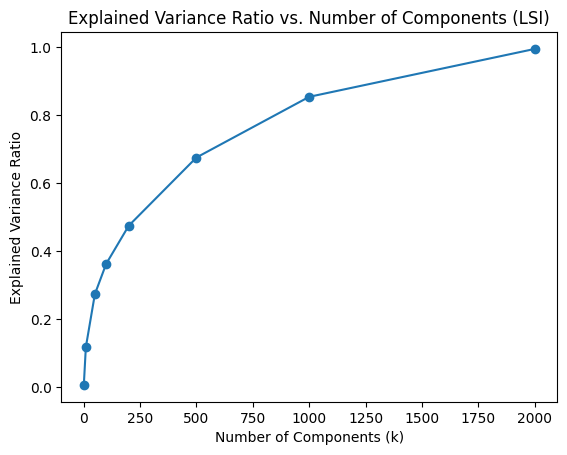

In [76]:
# NOT VALIDATED
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Define values of k
k_values = [1, 10, 50, 100, 200, 500, 1000, 2000]

# Plot explained variance ratio for different values of k
explained_variances = []

for k in k_values:
    lsi = TruncatedSVD(n_components=k, random_state=0)
    lsi.fit_transform(X_train_tfidf)
    explained_variances.append(lsi.explained_variance_ratio_.sum())

plt.plot(k_values, explained_variances, marker='o')
plt.xlabel('Number of Components (k)')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components (LSI)')
plt.show()

#### 4.1.2 What does the explained variance ratio plot look like? 

incomplete

#### 4.1.3 What does the plot’s concavity suggest?
incomplete 

#### 4.2.1 Calculate the reconstruction residual MSE error. 

In [77]:
# LSI
from sklearn.decomposition import TruncatedSVD

lsi = TruncatedSVD(n_components=50, random_state=0)
X_train_lsi = lsi.fit_transform(X_train_tfidf)
X_test_lsi = lsi.transform(X_test_tfidf)

In [78]:
# NMF
from sklearn.decomposition import NMF

nmf = NMF(n_components=50, random_state=42)
X_train_NMF = nmf.fit_transform(X_train_tfidf)
X_test_NMF = nmf.transform(X_test_tfidf)

In [79]:
# LSI Reconstructed Residual MSE Error 
USigmaVt = lsi.inverse_transform(X_train_lsi)
residual_MSE_lsi = np.sum(np.array(X_train_tfidf - USigmaVt)**2)

# NMF Reconstructed Residual MSE Error 
WH = np.dot(X_train_NMF, nmf.components_)
residual_MSE_nmf = np.sum(np.array(X_train_tfidf - WH)**2)

#### 4.2.2 Which one is larger, NMF or LSI and why? 

In [80]:
if residual_MSE_lsi > residual_MSE_nmf: 
    print("LSI has a larger residual MSE error than NMF.")
elif residual_MSE_lsi < residual_MSE_nmf: 
    print("NMF has a larger residual MSE error than LSI.")
else: 
    print("NMF has the same residual MSE error as LSI.")

NMF has a larger residual MSE error than LSI.


incomplete (explain why)

## Question 5: Classificaiton Algorithms (Hard Margin and Soft Margin)

#### 5.1.1 Train one SVM with γ = 1000 (hard margin), another with γ = 0.0001 (soft margin).

In [81]:
from sklearn.svm import SVC

df['label'] = df['root_label'].apply(lambda x: 1 if x == "climate" else 0)
dummy_train, dummy_test = train_test_split(df, test_size=0.2, random_state=42)

# Binary classification labels for training set
Y_train = dummy_train['label'].values

# Binary classification labels for testing set
Y_test = dummy_test['label'].values

In [82]:
# Hard Margin
hard_margin = SVC(C=1000, kernel='linear', random_state=42)

hard_margin = hard_margin.fit(X_train_lsi, Y_train)

Y_test_pred_hard = hard_margin.predict(X_test_lsi)

In [83]:
# Soft Margin
soft_margin = SVC(C=0.0001, kernel='linear', random_state=42)

soft_margin = soft_margin.fit(X_train_lsi, Y_train)

Y_test_pred_soft = soft_margin.predict(X_test_lsi)

#### 5.1.2 Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set. Which one performs better? What about for γ = 100000?

In [84]:
# NOT VALIDATED
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_roc_curve(y_test,decision_function,name=""):
    fpr = dict();tpr = dict();roc_auc = dict()
    fpr, tpr, thresholds = roc_curve(y_test, decision_function)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate');
    plt.title('%s ROC curve' % name);plt.legend(loc="lower right")

In [85]:
# NOT VALIDATED 
# ROC curve
def plot_roc(fpr, tpr, title="ROC Curve"):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")
    ax.set_title(title, fontsize=16)

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label, title="ROC Curve"):
    pipe.fit(train_data, train_label)
    # pipeline1.predict(twenty_test.data)

    if hasattr(pipe, 'decision_function'):
        prob_score = pipe.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = pipe.predict_proba(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score[:,1])

    plot_roc(fpr, tpr, title)

Hard Margin
Confusion Matrix:
 [[353  15]
 [  5 323]]
Accuracy: 0.9712643678160919
Recall: 0.9847560975609756
Precision: 0.9556213017751479
F-1 Score: 0.96996996996997


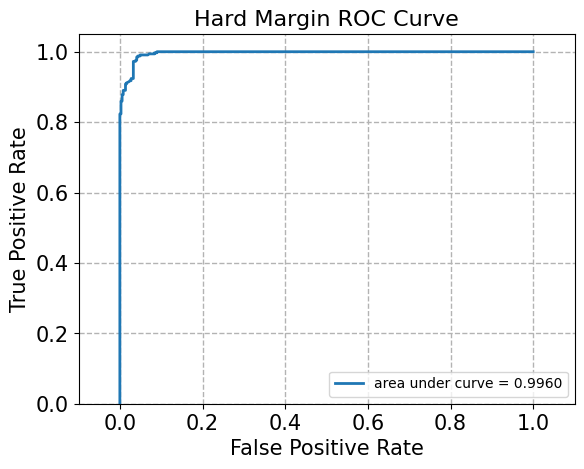

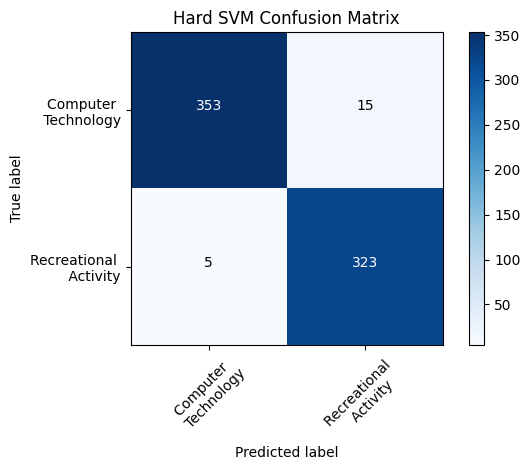

In [86]:
# Hard Margin 
print("Hard Margin")

# ROC Curve 
hard_m = SVC(C=1000, kernel='linear', random_state=42)
fit_predict_and_plot_roc(hard_m, X_train_lsi, Y_train, X_test_lsi, Y_test, "Hard Margin ROC Curve")

# Confusion Matrix 
print('Confusion Matrix:\n', confusion_matrix(Y_test, Y_test_pred_hard))
class_names = ['Computer \n Technology', 'Recreational \n Activity']
hard_cm = confusion_matrix(Y_test, Y_test_pred_hard) 
plt.figure(); plot_confusion_matrix(hard_cm, classes=class_names, title='Hard SVM Confusion Matrix')

# Statistics  
print('Accuracy:', accuracy_score(Y_test, Y_test_pred_hard))
print('Recall:', recall_score(Y_test, Y_test_pred_hard))
print('Precision:', precision_score(Y_test, Y_test_pred_hard))
print('F-1 Score:', f1_score(Y_test, Y_test_pred_hard))

# γ = 100000
hard_margin = SVC(C=100000, kernel='linear', random_state=42)

hard_margin = hard_margin.fit(X_train_lsi, Y_train)

Y_test_pred_hard = hard_margin.predict(X_test_lsi)

Soft Margin
Confusion:
 [[  0 368]
 [  0 328]]
Accuracy: 0.47126436781609193
Recall: 1.0
Precision: 0.47126436781609193
F-1 Score: 0.640625


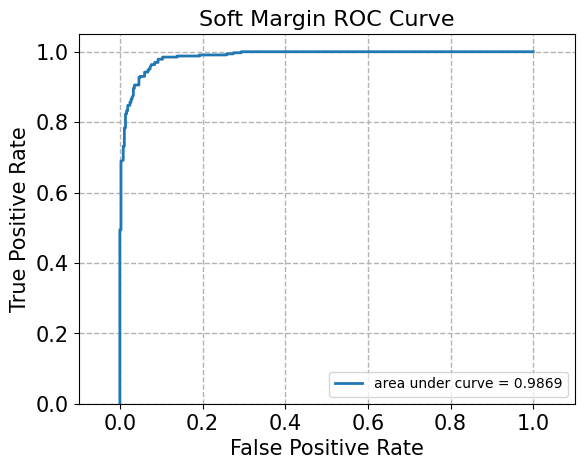

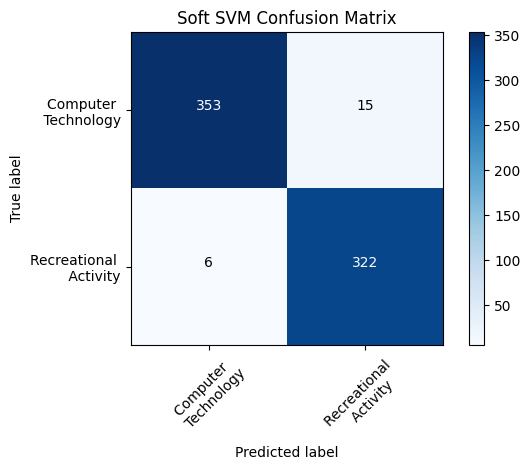

In [87]:
# Soft Margin 
print("Soft Margin")

# ROC Curve 
soft_m = SVC(C=0.0001, kernel='linear', random_state=42)
fit_predict_and_plot_roc(soft_m, X_train_lsi, Y_train, X_test_lsi, Y_test, "Soft Margin ROC Curve")

# Confusion Matrix 
print('Confusion:\n', confusion_matrix(Y_test, Y_test_pred_soft))
class_names = ['Computer \n Technology', 'Recreational \n Activity']
soft_cm = confusion_matrix(Y_test, Y_test_pred_hard) 
plt.figure(); plot_confusion_matrix(soft_cm, classes=class_names, title='Soft SVM Confusion Matrix')

# Statistics  
print('Accuracy:', accuracy_score(Y_test, Y_test_pred_soft))
print('Recall:', recall_score(Y_test, Y_test_pred_soft))
print('Precision:', precision_score(Y_test, Y_test_pred_soft))
print('F-1 Score:', f1_score(Y_test, Y_test_pred_soft))

# γ = 100000
svm_soft = SVC(C=100000, kernel='linear', random_state=42)

svm_soft = svm_soft.fit(X_train_lsi, Y_train)

Y_test_pred_soft = svm_soft.predict(X_test_lsi)

#### 5.1.3 What happens for the soft margin SVM? Why is the case? Analyze in terms of the confusion matrix.

incomplete

#### 5.1.4 Does the ROC curve reflect the performance of the soft-margin SVM? Why?

incomplete

#### 5.2.1 Use cross-validation to choose γ (use average validation 3 accuracy to compare): Using a 5-fold cross-validation, find the best value of the parameter γ in the range {10k| − 3 ≤ k ≤ 6, k ∈ Z}. 

In [88]:
from sklearn.model_selection import cross_val_score

# Cross Validation
gamma_vals = [10**k for k in range(-3, 7)]

best_gamma = None
best_accuracy = 0

# Iterate through gamma values 
for gamma in gamma_vals:
    svc = SVC(kernel='linear', C=gamma).fit(X_train_lsi, Y_train)
    scores = cross_val_score(svc, X_train_lsi, Y_train,cv=5, scoring='accuracy')

    # Set the best gamma if it is a higher mean score  
    if (np.mean(scores) > best_accuracy):
        best_gamma = gamma
        best_accuracy = np.mean(scores)

print(best_gamma)

1000


#### 5.2.2 Again, plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this best SVM.

Cross Validation
Confusion:
 [[353  15]
 [  5 323]]
Accuracy: 0.9712643678160919
Recall: 0.9847560975609756
Precision: 0.9556213017751479
F-1 Score: 0.96996996996997


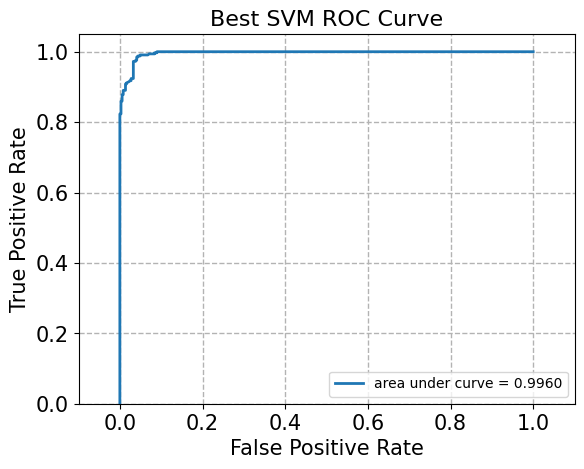

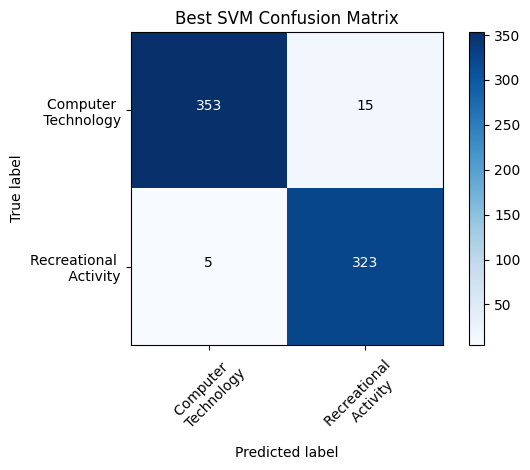

In [89]:
# Setup SVM for best SVM 
best_svm = SVC(kernel='linear', C=best_gamma)
best_svm = best_svm.fit(X_train_lsi, Y_train)
Y_test_pred_best = best_svm.predict(X_test_lsi)

print("Cross Validation")

# ROC Curve 
fit_predict_and_plot_roc(best_svm, X_train_lsi, Y_train, X_test_lsi, Y_test, "Best SVM ROC Curve")

# Confusion Matrix 
print('Confusion:\n', confusion_matrix(Y_test, Y_test_pred_best))
best_cm = confusion_matrix(Y_test, Y_test_pred_best) 
plt.figure(); plot_confusion_matrix(best_cm, classes=class_names, title='Best SVM Confusion Matrix')

# Statistics 
print('Accuracy:', accuracy_score(Y_test, Y_test_pred_best))
print('Recall:', recall_score(Y_test, Y_test_pred_best))
print('Precision:', precision_score(Y_test, Y_test_pred_best))
print('F-1 Score:', f1_score(Y_test, Y_test_pred_best))

## Question 6: Logistic Classifier

#### 6.1.1 Train a logistic classifier without regularization (you may need to come up with some way to approximate this if you use sklearn.linear model.LogisticRegression)

In [90]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression classifier without regularization
lr_wo_reg = LogisticRegression(C=10**10, solver='liblinear', random_state=42)
lr_wo_reg = lr_wo_reg.fit(X_train_lsi, Y_train)

Y_test_pred_lr = lr_wo_reg.predict(X_test_lsi)

#### 6.1.2 Plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1score of this classifier on the testing set.

Cross Validation
Confusion:
 [[352  16]
 [  9 319]]


Accuracy: 0.9640804597701149
Recall: 0.9725609756097561
Precision: 0.9522388059701492
F-1 Score: 0.9622926093514329


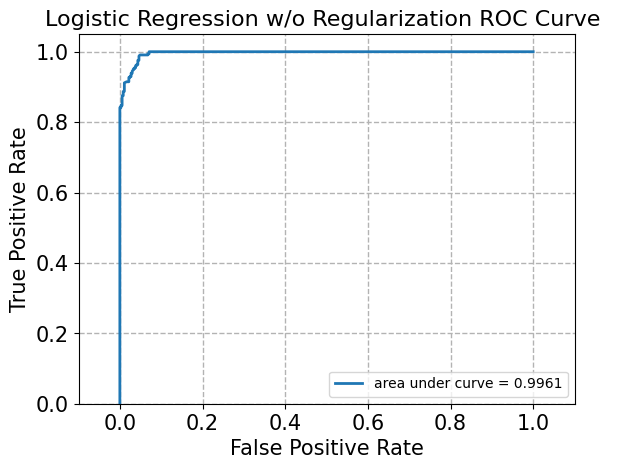

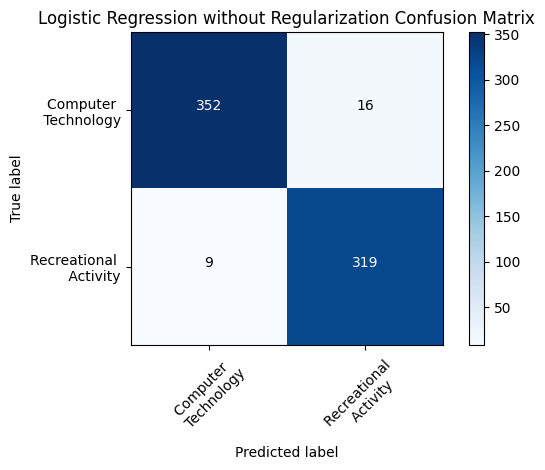

In [91]:
print("Cross Validation")

# ROC Curve 
fit_predict_and_plot_roc(lr_wo_reg, X_train_lsi, Y_train, X_test_lsi, Y_test, "Logistic Regression w/o Regularization ROC Curve ")

# Confusion Matrix 
print('Confusion:\n', confusion_matrix(Y_test, Y_test_pred_lr))
lr_wo_reg_cm = confusion_matrix(Y_test, Y_test_pred_lr) 
plt.figure(); plot_confusion_matrix(lr_wo_reg_cm, classes=class_names, title='Logistic Regression without Regularization Confusion Matrix')

# Statistics 
print('Accuracy:', accuracy_score(Y_test, Y_test_pred_lr))
print('Recall:', recall_score(Y_test, Y_test_pred_lr))
print('Precision:', precision_score(Y_test, Y_test_pred_lr))
print('F-1 Score:', f1_score(Y_test, Y_test_pred_lr))

### 6.2 Find the optimal regularization coefficient

#### 6.2.1 Using 5-fold cross-validation on the dimension-reduced-by-SVD training data, find the optimal regularization strength in the range {10k|−5 ≤ k ≤ 5, k ∈ Z} for logistic regression with L1 regularization and logistic regression with L2 regularization, respectively.

In [92]:
# Finding optimal regularization strength

def opt_reg_strength(X_train, Y_train, penalty):
    reg_strength = [10**k for k in range(-5, 6)]

    best_strength = None
    best_score = 0

    # Creates a Logistic Regression for each strength level 
    for strength in reg_strength:
        lr = LogisticRegression(C=strength, penalty=penalty, solver='liblinear', random_state=42).fit(X_train, Y_train)
        scores = cross_val_score(lr, X_train, Y_train,cv=5, scoring='accuracy')

        # updates best strength given if higher mean score 
        if (np.mean(scores) > best_score):
            best_strength = strength
            best_score = np.mean(scores)

    return best_strength

In [93]:
opt_strength_lr_l1 = opt_reg_strength(X_train_lsi, Y_train, 'l1')
opt_strength_lr_l2 = opt_reg_strength(X_train_lsi, Y_train, 'l2')

print("Optimal Regularization Strength for L1: ", opt_strength_lr_l1)
print("Optimal Regularization Strength for L2: ", opt_strength_lr_l2)

Optimal Regularization Strength for L1:  100
Optimal Regularization Strength for L2:  1000


#### 6.2.2 Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classifiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best parameters you found from the part above), using test data.

In [94]:
# Performance of Logistic Classifier w/o regularization
lr_wo_reg = LogisticRegression(C=10**10, solver='liblinear', random_state=42)
lr_wo_reg = lr_wo_reg.fit(X_train_lsi, Y_train)

Y_test_pred_lr = lr_wo_reg.predict(X_test_lsi)

# Statistics 
print("-"*20 + " Performance of Logistic Classifier w/o regularization "+ "-"*20)
print('Accuracy:', accuracy_score(Y_test, Y_test_pred_lr))
print('Recall:', recall_score(Y_test, Y_test_pred_lr))
print('Precision:', precision_score(Y_test, Y_test_pred_lr))
print('F-1 Score:', f1_score(Y_test, Y_test_pred_lr))

# Performance of Logistic Classifier w/ L1 regularization
lr_w_l1 = LogisticRegression(C=opt_strength_lr_l1, solver='liblinear', penalty='l1', random_state=42)
lr_w_l1 = lr_w_l1.fit(X_train_lsi, Y_train)

Y_test_pred_lr_l1 = lr_w_l1.predict(X_test_lsi)

# Statistics 
print("-"*20 + " Performance of Logistic Classifier w/ L1 regularization "+ "-"*20)
print('Accuracy:', accuracy_score(Y_test, Y_test_pred_lr_l1))
print('Recall:', recall_score(Y_test, Y_test_pred_lr_l1))
print('Precision:', precision_score(Y_test, Y_test_pred_lr_l1))
print('F-1 Score:', f1_score(Y_test, Y_test_pred_lr_l1))

# Performance of Logistic Classifier w/ L2 regularization
lr_w_l2 = LogisticRegression(C=opt_strength_lr_l2, solver='liblinear', penalty='l2', random_state=42)
lr_w_l2 = lr_w_l2.fit(X_train_lsi, Y_train)

Y_test_pred_lr_l2 = lr_w_l2.predict(X_test_lsi)

# Statistics 
print("-"*20 + " Performance of Logistic Classifier w/ L2 regularization "+ "-"*20)
print('Accuracy:', accuracy_score(Y_test, Y_test_pred_lr_l2))
print('Recall:', recall_score(Y_test, Y_test_pred_lr_l2))
print('Precision:', precision_score(Y_test, Y_test_pred_lr_l2))
print('F-1 Score:', f1_score(Y_test, Y_test_pred_lr_l2))

-------------------- Performance of Logistic Classifier w/o regularization --------------------
Accuracy: 0.9640804597701149
Recall: 0.9725609756097561
Precision: 0.9522388059701492
F-1 Score: 0.9622926093514329
-------------------- Performance of Logistic Classifier w/ L1 regularization --------------------
Accuracy: 0.9626436781609196
Recall: 0.9695121951219512
Precision: 0.9520958083832335
F-1 Score: 0.9607250755287009
-------------------- Performance of Logistic Classifier w/ L2 regularization --------------------
Accuracy: 0.9640804597701149
Recall: 0.9725609756097561
Precision: 0.9522388059701492
F-1 Score: 0.9622926093514329


#### 6.2.3 How does the regularization parameter affect the test error? How are the learnt coefficients affected? Why might one be interested in each type of regularization?

incomplete (explain why)

#### 6.2.4 Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary. What is the difference between their ways to find this boundary? Why do their performances differ? Is this difference statistically significant?

## Question 7: Naive Bayes Classifier

### 7.1.1 Evaluate and profile a Naive Bayes classifier: Train a GaussianNB classifier

In [95]:
from sklearn.naive_bayes import GaussianNB

# Train Gaussian Naive Bayes classifier 
gnb_cf = GaussianNB()

gnb_cf = gnb_cf.fit(X_train_lsi, Y_train)

Y_test_pred_gnb = gnb_cf.predict(X_test_lsi)

### 7.1.2 Plot the ROC curve and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of this classifier on the testing set.

Naive Bayes Classifier
Confusion:
 [[359   9]
 [ 60 268]]
Accuracy: 0.9008620689655172
Recall: 0.8170731707317073
Precision: 0.9675090252707581
F-1 Score: 0.8859504132231405


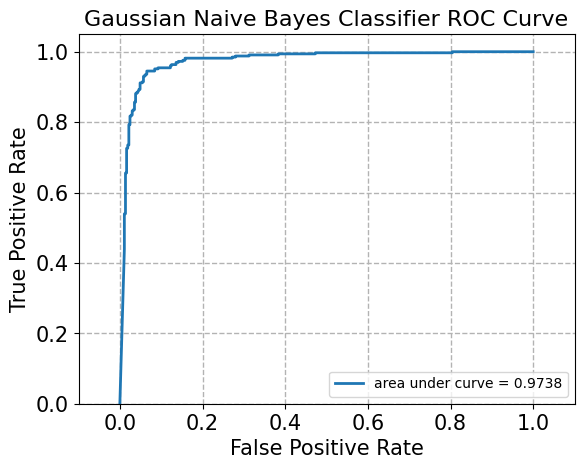

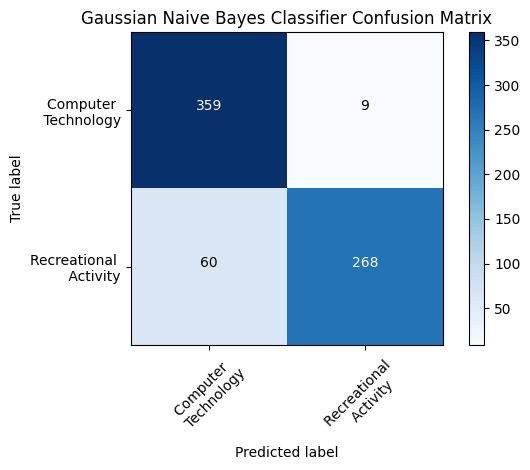

In [96]:
print("Naive Bayes Classifier")

# ROC Curve 
fit_predict_and_plot_roc(gnb_cf, X_train_lsi, Y_train, X_test_lsi, Y_test, "Gaussian Naive Bayes Classifier ROC Curve")

# Confusion Matrix 
print('Confusion:\n', confusion_matrix(Y_test, Y_test_pred_gnb))
gnb_cm = confusion_matrix(Y_test, Y_test_pred_gnb) 
plt.figure(); plot_confusion_matrix(gnb_cm, classes=class_names, title='Gaussian Naive Bayes Classifier Confusion Matrix')

# Statistics  
print('Accuracy:', accuracy_score(Y_test, Y_test_pred_gnb))
print('Recall:', recall_score(Y_test, Y_test_pred_gnb))
print('Precision:', precision_score(Y_test, Y_test_pred_gnb))
print('F-1 Score:', f1_score(Y_test, Y_test_pred_gnb))

## Question 8: Binary Classification (Pipeline)

### 8.1 Construct a Pipeline that performs feature extraction, dimensionality reduction and classification

In [102]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')), # vectorize (feature extraction)
    ('tfidf', TfidfTransformer()), # transformer
    ('reduce_dim', TruncatedSVD()), # dimensionality reduction
    ('clf', SVC()), # classification
])

### 8.2 The evaluation of each combination is performed with 5-fold cross-validation (use the average validation set accuracy across folds).

#### 8.2.1 In addition to any other hyperparameters you choose, your gridsearch must at least include: Loading Data, Feature Extraction, Dimensionality Reduction, Classifier, Other options. 

In [103]:
# check loading data section !!!!!!!!!

hyperparameters = [
    {
        'clean': [train['full_text'].map(clean)], # Loading Data: Cleaning data ???
        'vect__min_df': [3,5], # Feature Extraction: min_df (3 vs 5)
        'reduce_dim': [# Dimensionality Reduction: LSI vs NMF (k = [5, 30, 80])
            TruncatedSVD(n_components=5, random_state=42),
            TruncatedSVD(n_components=30, random_state=42),
            TruncatedSVD(n_components=80, random_state=42),
            NMF(n_components=5, random_state=42),
            NMF(n_components=30, random_state=42),
            NMF(n_components=80, random_state=42)
        ], 
        'clf': [ # Classifier: SVM (best gamma), L1 Regularization, L2 Regularization, GaussianNB
            SVC(C=best_gamma, kernel='linear'), 
            LogisticRegression(C=opt_strength_lr_l1, penalty = 'l1', solver='liblinear', random_state=42),
            LogisticRegression(C=opt_strength_lr_l2, penalty = 'l2', random_state=42),
            GaussianNB(),
        ]
    }
]

### 8.3 What are the 5 best combinations? Report their performances on the testing set.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create Grid 

grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=hyperparameters, scoring='accuracy')
grid.fit(X_train_lsi, Y_train)
result = pd.DataFrame(grid.cv_results_)

In [ ]:
# NOT VALIDATED
pd.set_option('display.max_colwidth', -1)

result.head()